In [1]:
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
keras.backend.set_image_dim_ordering('th')
weights_path = 'yolo-tiny.weights'
is_freeze = True

In [3]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1), 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [4]:
def say(*words, verbalise=False):
    if verbalise:
        print(list(words))

def convert_darkweights2keras(model, weigths_path, verbalise=False):
    data = np.fromfile(weights_path, np.float32)
    data = data[4:]
    say("weights shape : ", data.shape, verbalise=verbalise)
    idx = 0
    for i,layer in enumerate(model.layers):
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[idx:idx+np.prod(bshape)].reshape(bshape)
            idx += np.prod(bshape)
            ker = data[idx:idx+np.prod(kshape)].reshape(kshape)
            idx += np.prod(kshape)
            layer.set_weights([ker,bia])
    say("convert np weights file -> kears models", "Successful", verbalise=verbalise)

In [5]:
convert_darkweights2keras(model, weights_path, verbalise=True)

['weights shape : ', (45089374,)]
['convert np weights file -> kears models', 'Successful']


In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 112, 112)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Test Forward Path

In [7]:
from utils.utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box
# from utils.BoxUtils import post_progress

1 (424, 640, 3)
2 (448, 448, 3)
3 (3, 448, 448)
4 (1, 3, 448, 448)
5 (1, 1470)


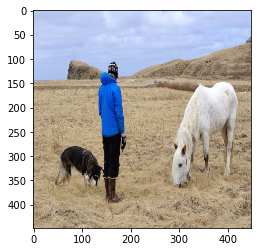

In [11]:
imagePath = './test/my_testset/person.jpg'
image = plt.imread(imagePath)
print("1", image.shape)
resized = cv2.resize(image,(448,448))
plt.imshow(resized)
print("2", resized.shape)
batch = np.transpose(resized,(2,0,1))
print("3", batch.shape)
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
print("4", batch.shape)
out = model.predict(batch)
print("5", out.shape)

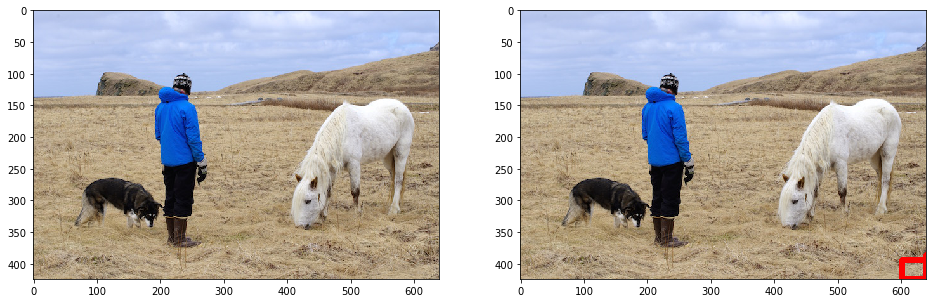

In [13]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.01)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

1 (424, 640, 3)
2 (448, 448, 3)
3 (3, 448, 448)
4 (1, 3, 448, 448)
5 (1, 1470)
max_index: 16, left: 412, top: 134, right: 592, bottom: 330
max_index: 11, left: 68, top: 241, right: 227, bottom: 372
max_index: 14, left: 184, top: 112, right: 294, bottom: 333
max_index: 11, left: 133, top: 274, right: 278, bottom: 374
max_index: 11, left: 408, top: 159, right: 579, bottom: 331


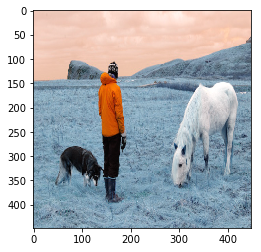

In [29]:
from utils.BoxUtils import post_progress

imagePath = './test/my_testset/person.jpg'
image = cv2.imread(imagePath)
print("1", image.shape)
resized = cv2.resize(image,(448,448))
plt.imshow(resized)
print("2", resized.shape)
np_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
batch = np.transpose(np_img,(2,0,1))
print("3", batch.shape)
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
print("4", batch.shape)
out = model.predict(batch)
print("5", out.shape)

# np_img_origin = cv2.imread('test/my_testset/person.jpg')
# print("1-2", np_img_origin.shape)
# # np_img_origin = cv2.imread('test/test1.jpg')
# resized_img = cv2.resize(np_img_origin, (448, 448))
# print("2-2", resized_img.shape)
# np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
# print("3-2", np_img.shape)
# # np_img = 2*(np_img/255.) - 1
# np_img = np_img.astype(np.float32)
# # plt.imshow(np_img)
# # np_img = np.expand_dims(np_img, axis=0)
# np_img = np_img / 255.0 * 2 - 1
# np_img = np.reshape(np_img, (1, 3,448,448))
# out = model.predict(np_img)
out_img = post_progress(out[0], im=image, is_save=True, threshold=0.1)
# plt.imshow(out_img)
